In [ ]:
# !conda install python-snappy

In [2]:
# %matplotlib widget
%matplotlib inline
# %matplotlib qt 

import json

import requests
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import folium
import geopandas as gpd
from shapely.geometry import box, Polygon
from pyproj import CRS
from tqdm.notebook import tqdm
from tqdm import trange

In [3]:
# remove folium warning
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)

In [38]:
dates = requests.get('https://openaltimetry.org/data/icesat2/getTrackDate').json()
tracks = gpd.read_file(r"../data/icesat-2/icesat2_tracks.shp")

# NL
# extents = [5.35,53.4,6.2,53.5] 
# zoom = 10

# DK
extents = [8.0557, 54.8955, 8.7615, 55.5938]
zoom = 8

polygon_geom = Polygon(zip([extents[0],extents[2],extents[2],extents[0]], [extents[1],extents[1],extents[3],extents[3]]))
polygon = gpd.GeoDataFrame(index=[0], crs=CRS('EPSG:3857'), geometry=[polygon_geom])       

# Clip data
tracks_clip = gpd.clip(tracks, polygon)
track_ids = tracks_clip.TrackId.values

In [5]:
center = [polygon_geom.centroid.xy[1][0], polygon_geom.centroid.xy[0][0]]

In [6]:
m = folium.Map(center, zoom_start=zoom)
folium.GeoJson(polygon_geom).add_to(m)
folium.GeoJson(tracks_clip).add_to(m)
folium.LatLngPopup().add_to(m)
m


In [7]:
track_ids

array(['69', '229', '511', '671', '1014', '1113'], dtype=object)

In [9]:
# track_id, track_date
overpasses = []
for track_id in track_ids:
    for track_date in dates['track_{}'.format(track_id)].split(','):
        overpasses.append([track_id, track_date])

In [11]:
rows = []

# download data for all track_id, track_date combinations
with tqdm(overpasses, ncols='100%') as t:
    log = lambda s: t.set_description(s); t.refresh()
    
    for track_id, track_date in t:
        log(f'Downloading data for track: {track_id}, date: {track_date}')

        # Paste the OpenAltimetry API URL for Photon here: 
        OA_API_URL = 'https://openaltimetry.org/data/api/icesat2/atl03?' \
            '&minx={}&miny={}&maxx={}&maxy={}&date={}&trackId={}' \
            '&beamName=gt3r&beamName=gt3l&beamName=gt2r&beamName=gt2l&beamName=gt1r&beamName=gt1l' \
            .format(extents[0], extents[1], extents[2], extents[3], track_date, track_id)

        # This function will request the 6 beams data using OpenAltimetry's API
        r = requests.get(OA_API_URL + '&client=jupyter')
        photon_data = r.json()

        # iterate over 6 beams
        for beam in photon_data:
            # every beam has data series with different confidences:
            #
            # {'beam_name': 'gt3r',
            #  'total_photon_count': 43383,
            #  'select_photon_count': 43383,
            #  'percentage': 100.0,
            #  'series': [{'name': 'Noise',
            #    'photon_count': 580,
            #    'data': [[55.48735236638138, 8.49802945875813, 37.546936],
            #     [55.48734604692815, 8.498028327844818, 42.50964],            
            beam_name = beam['beam_name']
            for s in beam['series']:
                # every series has name (confidence)
                series_name = s['name']
                
                for o in s['data']:
                    # add rows
                    row = {
                        'track_id': track_id,
                        'date': track_date,
                        'beam': beam_name,
                        'series': series_name,
                        'lon': round(o[0], 6),
                        'lat': round(o[1], 6),
                        'h': o[2],
                    }
            
                    rows.append(row)


In [12]:
df = pd.DataFrame(rows)

In [13]:
df

,track_id,date,beam,series,x,y,h
0,69,2019-01-01,gt3r,Noise,55.589424,8.515854,45.353355
1,69,2019-01-01,gt3r,Noise,55.588817,8.515745,106.844666
2,69,2019-01-01,gt3r,Noise,55.586167,8.515275,26.828594
3,69,2019-01-01,gt3r,Noise,55.586059,8.515256,32.035164
4,69,2019-01-01,gt3r,Noise,55.586015,8.515249,24.463839
...,...,...,...,...,...,...,...
5583283,1113,2020-03-08,gt1l,Low,55.545941,8.658705,330.743000
5583284,1113,2020-03-08,gt1l,Low,55.546439,8.658633,-213.183560
5583285,1113,2020-03-08,gt1l,Low,55.546509,8.658621,-210.123960
5583286,1113,2020-03-08,gt1l,Low,55.546560,8.658612,-209.074980


In [14]:
df.memory_usage()

Index            128
track_id    44666304
date        44666304
beam        44666304
series      44666304
x           44666304
y           44666304
h           44666304
dtype: int64

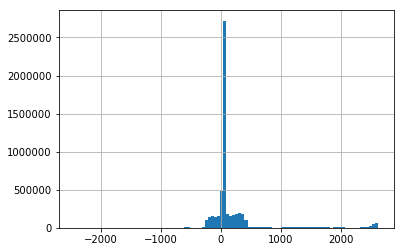

In [15]:
df.h.hist(bins=100)

In [4]:
# df.to_parquet('../data/out/icesat-2-DK.parquet')
df = pd.read_parquet('../data/out/icesat-2-DK.parquet')

In [35]:
df.columns

Index(['track_id', 'date', 'beam', 'series', 'x', 'y', 'h'], dtype='object')

In [18]:
df.series.unique()

array(['Noise', 'Buffer', 'Low', 'Medium', 'High'], dtype=object)

In [19]:
df.beam.unique()

array(['gt3r', 'gt3l', 'gt2r', 'gt2l', 'gt1r', 'gt1l'], dtype=object)

In [9]:
track_ids = df.track_id.unique()
track_ids

array(['69', '229', '511', '671', '1014', '1113'], dtype=object)

In [40]:
[ [track_id, df[df.track_id == track_id].date.unique()] for track_id in track_ids]

[['69',
  array(['2019-01-01', '2019-04-02', '2019-10-01', '2019-12-31',
         '2020-03-31'], dtype=object)],
 ['229',
  array(['2019-01-12', '2019-04-13', '2019-10-11', '2020-01-10'],
        dtype=object)],
 ['511',
  array(['2018-11-01', '2019-01-30', '2019-05-01', '2019-07-31',
         '2019-10-30', '2020-01-29'], dtype=object)],
 ['671',
  array(['2018-11-11', '2019-02-10', '2019-05-12', '2019-08-11',
         '2019-11-09', '2020-02-08'], dtype=object)],
 ['1014',
  array(['2018-12-04', '2019-03-04', '2019-06-03', '2019-09-02',
         '2019-12-02', '2020-03-02'], dtype=object)],
 ['1113',
  array(['2018-12-10', '2019-03-11', '2019-06-10', '2019-09-08',
         '2019-12-08', '2020-03-08'], dtype=object)]]

In [22]:
# for track_id in track_ids:
#     track_df = df[df.track_id == track_id]
#     for date in track_df.date.unique():
#         track_df2 = track_df[track_df.date == date]
#         print(track_id, date, len(track_df2))
        

In [15]:
print(df.beam.unique())

['gt3r' 'gt3l' 'gt2r' 'gt2l' 'gt1r' 'gt1l']


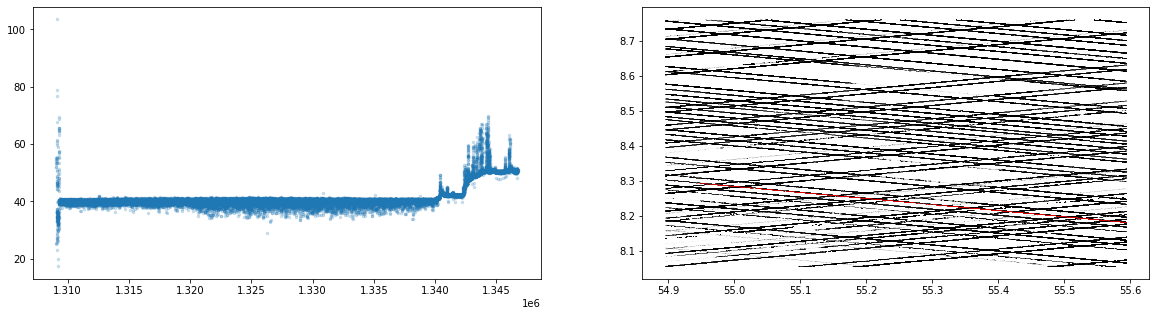

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

# (df.series != 'Noise') & (df.series != 'Buffer') & 
data = df [(df.series != 'Noise') & (df.track_id == '229') & (df.date == '2020-01-10') & (df.beam == 'gt2l')]

ax[0].plot(data.h, '.', markersize=5, alpha=0.2)
ax[1].plot(df.x, df.y, 'k.', markersize=0.1, alpha=0.2)
ax[1].plot(data.x, data.y, 'r.', markersize=0.1, alpha=0.2)
plt.show()
